In [ ]:
# This example uses collaborative approach
# https://github.com/amitkaps/recommendation/blob/master/Groceries/data/groceries.csv
# This dataset taken from the above link of github
# Python and PyTorch

In [67]:
#lib
import pandas as pd

file_path = "C:/Users/athma/Downloads/groceries.csv"
data = pd.read_csv(file_path)

# Check if the person column exists
if 'Person' not in data.columns:
    raise ValueError("The dataset must have a 'Person' column.")

# Print unique values
unique_persons = data['Person'].unique()
print("Unique Persons in the dataset:")
print(unique_persons)


Unique Persons in the dataset:
[   1    2    3 ... 9833 9834 9835]


In [69]:
if 'item' not in data.columns:
    raise ValueError("The dataset must have an 'item' column.")

# Print unique values
unique_items = data['item'].unique()
print("Unique Items in the dataset")
print(unique_items)

Unique Items in the dataset
['citrus fruit' 'semi-finished bread' 'margarine' 'ready soups'
 'tropical fruit' 'yogurt' 'coffee' 'whole milk' 'pip fruit'
 'cream cheese ' 'meat spreads' 'other vegetables' 'condensed milk'
 'long life bakery product' 'butter' 'rice' 'abrasive cleaner'
 'rolls/buns' 'UHT-milk' 'bottled beer' 'liquor (appetizer)' 'pot plants'
 'cereals' 'white bread' 'bottled water' 'chocolate' 'curd' 'flour'
 'dishes' 'beef' 'frankfurter' 'soda' 'chicken' 'sugar'
 'fruit/vegetable juice' 'newspapers' 'packaged fruit/vegetables'
 'specialty bar' 'butter milk' 'pastry' 'processed cheese' 'detergent'
 'root vegetables' 'frozen dessert' 'sweet spreads' 'salty snack'
 'waffles' 'candy' 'bathroom cleaner' 'canned beer' 'sausage'
 'brown bread' 'shopping bags' 'beverages' 'hamburger meat' 'spices'
 'hygiene articles' 'napkins' 'pork' 'berries' 'whipped/sour cream'
 'artif. sweetener' 'grapes' 'dessert' 'zwieback' 'domestic eggs'
 'spread cheese' 'misc. beverages' 'hard cheese' '

In [ ]:
# Persons and items are represented as embeddings (vectors) of size embedding_dim
# (x person, x item) 

C:\Users\athma\AppData\Local\Temp\ipykernel_1488\3655079637.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts[:15].values, y=item_counts[:15].index, palette='viridis')


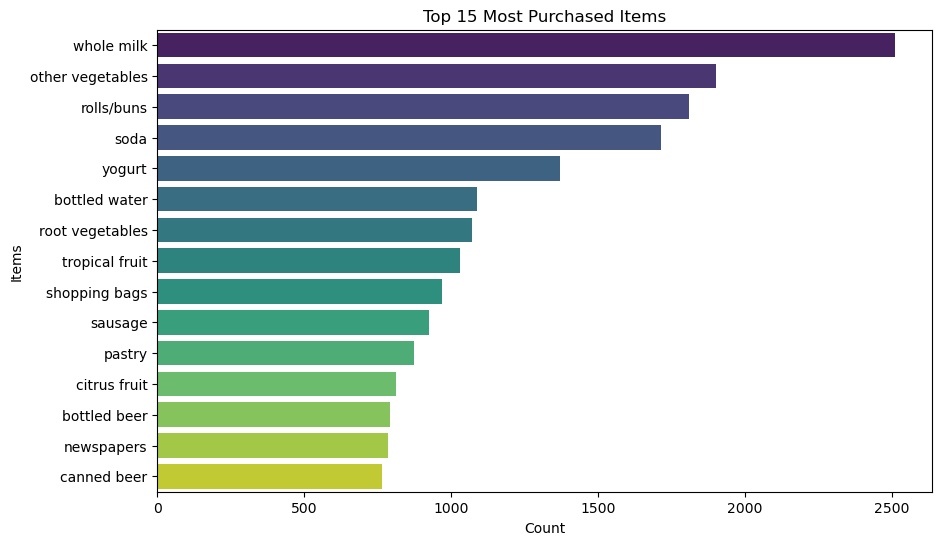

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the frequency of each item
item_counts = data['item'].value_counts()

# Plot the top 15 most common items
plt.figure(figsize=(10, 6))
sns.barplot(x=item_counts[:15].values, y=item_counts[:15].index, palette='viridis')
plt.title('Top 15 Most Purchased Items')
plt.xlabel('Count')
plt.ylabel('Items')
plt.show()


<Axes: xlabel='Person', ylabel='item'>

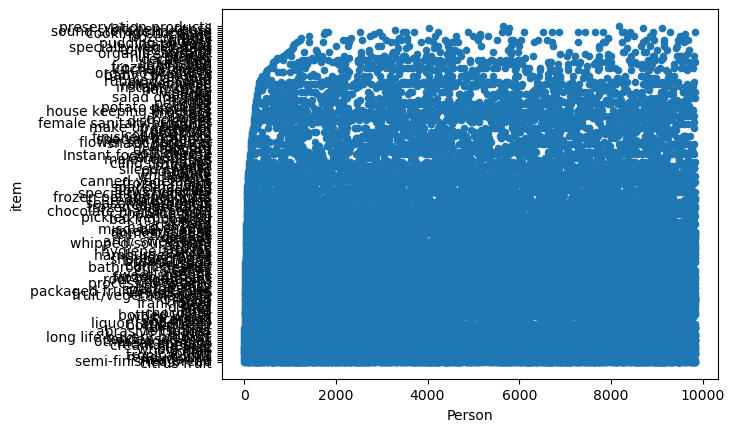

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data.plot(kind = 'scatter', x = 'Person', y = 'item')

In [23]:
#Lib's
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

# load and read data 
file_path = "C:/Users/athma/Downloads/groceries.csv"
data = pd.read_csv(file_path)


if 'Person' not in data.columns or 'item' not in data.columns:
    raise ValueError("The dataset must have 'Person' and 'item' columns.")

# Preprocess 
person_encoder = LabelEncoder()
item_encoder = LabelEncoder()

data['PersonID'] = person_encoder.fit_transform(data['Person'])
data['ItemID'] = item_encoder.fit_transform(data['item'])


# Dataset
class PersonItemDataset(Dataset):
    def __init__(self, data):
        self.persons = torch.tensor(data['PersonID'].values, dtype=torch.long)
        self.items = torch.tensor(data['ItemID'].values, dtype=torch.long)
        self.ratings = torch.tensor([1.0] * len(data), dtype=torch.float)  

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.persons[idx], self.items[idx], self.ratings[idx]

dataset = PersonItemDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# CF Model 
# (x person, x item) embedding
class CFRecommendationModel(torch.nn.Module):
    def __init__(self, num_persons, num_items, embedding_dim=50):
        super(CFRecommendationModel, self).__init__()
        self.person_embedding = torch.nn.Embedding(num_persons, embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)

    def forward(self, person_ids, item_ids):
        person_embeds = self.person_embedding(person_ids)
        item_embeds = self.item_embedding(item_ids)
        return (person_embeds * item_embeds).sum(dim=1)



# Initialize model
num_persons = len(person_encoder.classes_)
num_items = len(item_encoder.classes_)
model = CFRecommendationModel(num_persons, num_items)

# Training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# You can adjust the number of Epochs based on your dataset
for epoch in range(15):  
    model.train()
    epoch_loss = 0
    for person_ids, item_ids, ratings in dataloader:
        optimizer.zero_grad()
        predictions = model(person_ids, item_ids)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")



# Generation of recommendations
#def recommend_items(person_id, model, num_recommendations=5):
    #model.eval()
    #person_idx = torch.tensor([person_encoder.transform([person_id])[0]])
    #all_items = torch.arange(num_items)
    
    #with torch.no_grad():
     #   scores = model(person_idx.repeat(num_items), all_items)

def recommend_items(person_id, model, num_recommendations=5):
    model.eval()
    person_idx = torch.tensor([person_encoder.transform([person_id])[0]], dtype=torch.long)
    all_items = torch.arange(num_items, dtype=torch.long)
    
    # Broadcast person IDs to match item IDs
    person_idx = person_idx.repeat(len(all_items))
    
    with torch.no_grad():
        scores = model(person_idx, all_items)
        
    # Get top recommended items
    top_items = torch.topk(scores, num_recommendations).indices
    return item_encoder.inverse_transform(top_items.numpy())


# Checking the model recommendations, you can change the person_id to verify 
person_id = 15  
recommended_items = recommend_items(person_id, model, num_recommendations=5)
print(f"Recommended items for Person {person_id}: {recommended_items}")


Epoch 1, Loss: 28408.4797
Epoch 2, Loss: 3060.3028
Epoch 3, Loss: 1850.3822
Epoch 4, Loss: 1509.0658
Epoch 5, Loss: 1086.1641
Epoch 6, Loss: 700.7168
Epoch 7, Loss: 595.9880
Epoch 8, Loss: 549.8331
Epoch 9, Loss: 520.7065
Epoch 10, Loss: 481.4734
Epoch 11, Loss: 435.2063
Epoch 12, Loss: 426.0946
Epoch 13, Loss: 415.0872
Epoch 14, Loss: 392.0887
Epoch 15, Loss: 383.0799
Recommended items for Person 15: ['baby food' 'Instant food products' 'nut snack' 'spices'
 'finished products']


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotting_specific_person_and_item(data, person_id):
    # now we need to filter the data for specific person and interaction with each item
    person_data = data[data['Person'] == person_id]
    item_counts = person_data['item'].value_counts()
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=item_counts.values, y=item_counts.index, palette= "viridis")
    plt.title(f"Items purchased by a specific person ({person_id})", fontsize=12)
    plt.xlabel("Count", fontsize=10)
    plt.ylabel("Items", fontsize=10)
    plt.show()
    

C:\Users\athma\AppData\Local\Temp\ipykernel_1488\1455645542.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.values, y=item_counts.index, palette= "viridis")


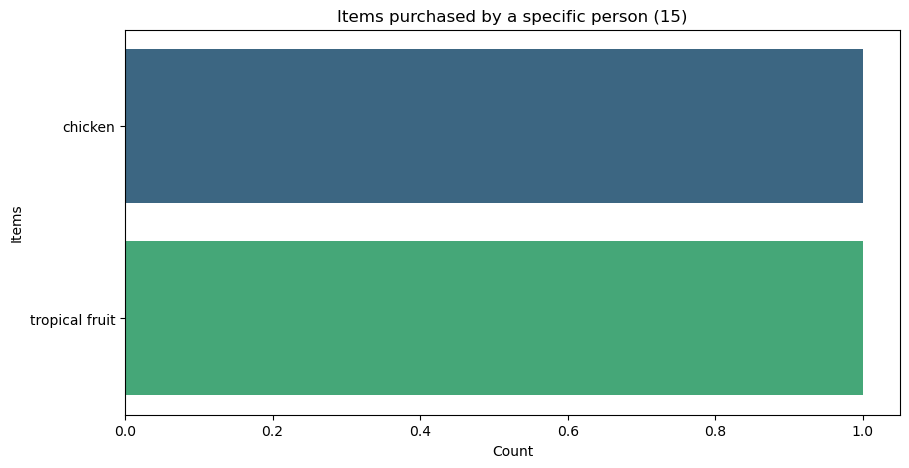

In [45]:
person_id = 15
plotting_specific_person_and_item(data, person_id)

In [47]:
person_id = 15  
person_items = data[data['Person'] == person_id]['item']
print(f"Items associated with Person {person_id}:")
print(person_items.tolist())


Items associated with Person 15:
['chicken', 'tropical fruit']


In [65]:
# Checking the model recommendations, you can change the person_id to verify 
person_id = 15  
recommended_items = recommend_items(person_id, model, num_recommendations=5)
print(f"Recommended items for Person {person_id}: {recommended_items}")

Recommended items for Person 15: ['baby food' 'Instant food products' 'nut snack' 'spices'
 'finished products']
